In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
import seaborn as sns

<h2>После того как мы запарсили сайт риа-новостей по двум наиболее репрезентативным категориям - экономика и политика (файл economics_parser.py и politics_parser.py, их в блокнот не стали вставлять, так как парсер работает на selenium и работает достаточно долго, так как надо каждый раз подгружать по 10 новостей с задержкой 4 секунды, и получается, что на работу уходит околок 2.5 часов), хотелось бы обработать, так как удобнее всего будет смотреть по дням, так что возмем среднее кол-во просмотров новостей за каждую неделю с 4 июня 2023 по 1 июня 2024, чтобы более менее обработать выбросы и учитывать тезис, что резонансные события сохраняют резонанс на продолжительный период.</h2>

In [2]:
def process_csv(file_name):
    data = {}
    with open(file_name, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if len(row) >= 2:
                views = int(row[0])
                date_str = row[1].split(",")[0]
                date = datetime.strptime(date_str, "%d %B %Y")
                week_start = date - timedelta(days=date.weekday())
                week_end = week_start + timedelta(days=6)
                week = (week_start.strftime("%d %B %Y"), week_end.strftime("%d %B %Y"))
                if week in data:
                    data[week].append(views)
                else:
                    data[week] = [views]
    return data

def calculate_average(data):
    average_data = {}
    for week, views_list in data.items():
        if views_list:
            average_data[week] = sum(views_list) / len(views_list)
        else:
            average_data[week] = 0
    return average_data

def write_to_csv(data, output_file):
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Week', 'Average Views'])
        for week, average_views in sorted(data.items(), key=lambda x: datetime.strptime(x[0][0], "%d %B %Y")):
            writer.writerow([f"{week[0]} - {week[1]}", int(average_views)])

def main():
    economy_data = process_csv("economy_processed.csv")
    average_economy = calculate_average(economy_data)
    write_to_csv(average_economy, "average_economy_weekly.csv")
    news_data = process_csv("politics_processed.csv")
    average_news = calculate_average(news_data)
    write_to_csv(average_news, "average_politics_weekly.csv")

if __name__ == "__main__":
    main()


<h2> Теперь в файлах average_economy.csv и average_politics.csv хранятся средние числа просмотров новостей по дням</h2>

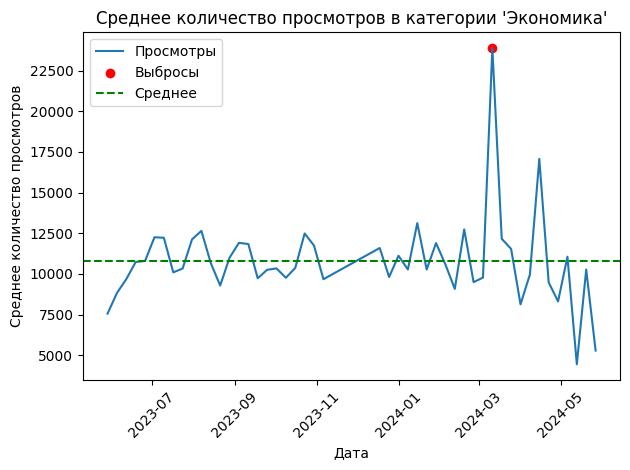

Среднее количество просмотров: 10787.333333333334
Стандартное отклонение: 2722.9036992805227
Выбросы: [(datetime.datetime(2024, 3, 11, 0, 0), 23875)]


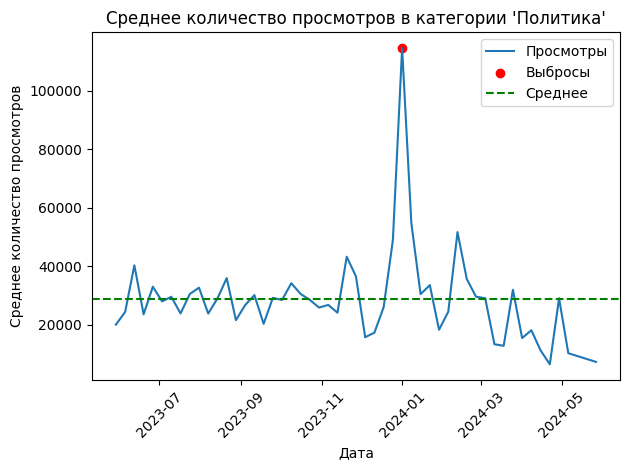

Среднее количество просмотров: 28709.41176470588
Стандартное отклонение: 15811.498909705759
Выбросы: [(datetime.datetime(2024, 1, 1, 0, 0), 114548)]


In [3]:
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

def read_csv(file_name):
    data = {}
    with open(file_name, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  
        for row in reader:
            date_range = row[0]
            views = int(row[1]) 
            start_date_str, end_date_str = date_range.split(" - ")
            try:
                start_date = datetime.strptime(start_date_str, "%d %B %Y")
                end_date = datetime.strptime(end_date_str, "%d %B %Y")
                data[start_date] = views
            except ValueError:
                print(f"Не удалось разобрать дату: {date_range}")
    return data

def plot_data(data, title):
    dates = list(data.keys())
    views = list(data.values())
    mean_views = np.mean(views)
    std_views = np.std(views)
    outliers = [(date, view) for date, view in zip(dates, views) if abs(view - mean_views) > 3 * std_views]
    outlier_dates = [date for date, view in outliers]
    outlier_views = [view for date, view in outliers]
    plt.plot(dates, views, label='Просмотры')
    plt.scatter(outlier_dates, outlier_views, color='red', label='Выбросы')
    plt.axhline(mean_views, color='green', linestyle='--', label='Среднее')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Среднее количество просмотров')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Среднее количество просмотров: {mean_views}")
    print(f"Стандартное отклонение: {std_views}")
    print(f"Выбросы: {outliers}")

def main():
    
    average_economy_data = read_csv("average_economy_weekly.csv")
    plot_data(average_economy_data, "Среднее количество просмотров в категории 'Экономика'")
    average_politics_data = read_csv("average_politics_weekly.csv")       
    plot_data(average_politics_data, "Среднее количество просмотров в категории 'Политика'")
    
if __name__ == "__main__":
    main()


<h2>Объединим датафреймы и посмотрим базовые метрики</h2>

In [4]:
def read_csv(file_name):
    data = []
    with open(file_name, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            date_range = row[0]
            views = int(row[1])
            start_date_str, end_date_str = date_range.split(" - ")
            try:
                start_date = datetime.strptime(start_date_str, "%d %B %Y")
                end_date = datetime.strptime(end_date_str, "%d %B %Y")
                data.append({'Дата начала': start_date, 'Дата окончания': end_date, 'Просмотры': views})
            except ValueError:
                print(f"Не удалось разобрать дату: {date_range}")
    return pd.DataFrame(data)

average_economy_data = read_csv("average_economy_weekly.csv")
average_politics_data = read_csv("average_politics_weekly.csv")
print("Анализ для категории 'Экономика':")
mean_views_economy = average_economy_data['Просмотры'].mean()
median_views_economy = average_economy_data['Просмотры'].median()
max_views_economy = average_economy_data['Просмотры'].max()
min_views_economy = average_economy_data['Просмотры'].min()
print(f"Среднее количество просмотров: {mean_views_economy}")
print(f"Медиана просмотров: {median_views_economy}")
print(f"Максимальное количество просмотров: {max_views_economy}")
print(f"Минимальное количество просмотров: {min_views_economy}")
print("\n\nАнализ для категории 'Политика':")
mean_views_politics = average_politics_data['Просмотры'].mean()
median_views_politics = average_politics_data['Просмотры'].median()
std_views_politics = average_politics_data['Просмотры'].std()
max_views_politics = average_politics_data['Просмотры'].max()
min_views_politics = average_politics_data['Просмотры'].min()
print(f"Среднее количество просмотров: {mean_views_politics}")
print(f"Медиана просмотров: {median_views_politics}")
print(f"Стандартное отклонение: {std_views_politics}")
print(f"Максимальное количество просмотров: {max_views_politics}")
print(f"Минимальное количество просмотров: {min_views_politics}")
merged_df = pd.merge(average_economy_data, average_politics_data, on=['Дата начала', 'Дата окончания'], suffixes=('_экономика', '_политика'))
merged_df.head()

Анализ для категории 'Экономика':
Среднее количество просмотров: 10787.333333333334
Медиана просмотров: 10358.5
Максимальное количество просмотров: 23875
Минимальное количество просмотров: 4452


Анализ для категории 'Политика':
Среднее количество просмотров: 28709.41176470588
Медиана просмотров: 28429.0
Стандартное отклонение: 15968.831132147992
Максимальное количество просмотров: 114548
Минимальное количество просмотров: 6426


Дата начала Дата окончания  Просмотры_экономика  Просмотры_политика
0  2023-05-29     2023-06-04                 7563               19988
1  2023-06-05     2023-06-11                 8831               24308
2  2023-06-12     2023-06-18                 9688               40273
3  2023-06-19     2023-06-25                10736               23502
4  2023-06-26     2023-07-02                10802               32963

<h2>Посмотрим на корреляцию</h2>

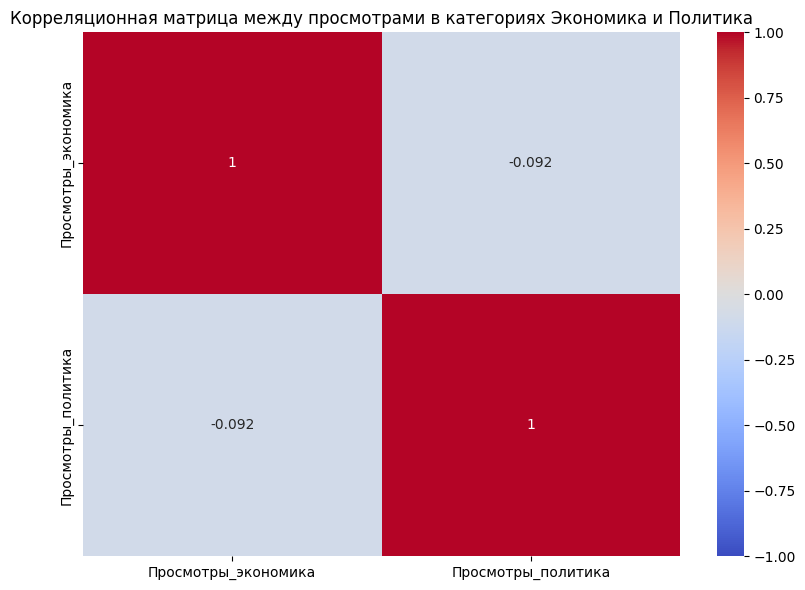

In [5]:
correlation_matrix = merged_df[['Просмотры_экономика', 'Просмотры_политика']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица между просмотрами в категориях Экономика и Политика')
plt.tight_layout()
plt.show()

<h2>Вывод:</h2>

<h3>Категория политики демонстрирует значительно выше среднее количество просмотров (28709 просмотров в неделю), по сравнению с категорией экономики (9683 просмотров в неделю). Медианные значения также подтверждают более высокий уровень интереса к политическим новостям (28429 против 10546 соответственно). Однако категория политики также характеризуется более высокой вариабельностью в просмотрах, отражающейся в большем стандартном отклонении данных (15968), что может быть связано с быстрыми изменениями интереса к различным политическим событиям. В то время как категория экономики демонстрирует более умеренную вариабельность и стабильный, но менее высокий уровень общего интереса.</h3>

<h2>Анализ темпов роста</h2>

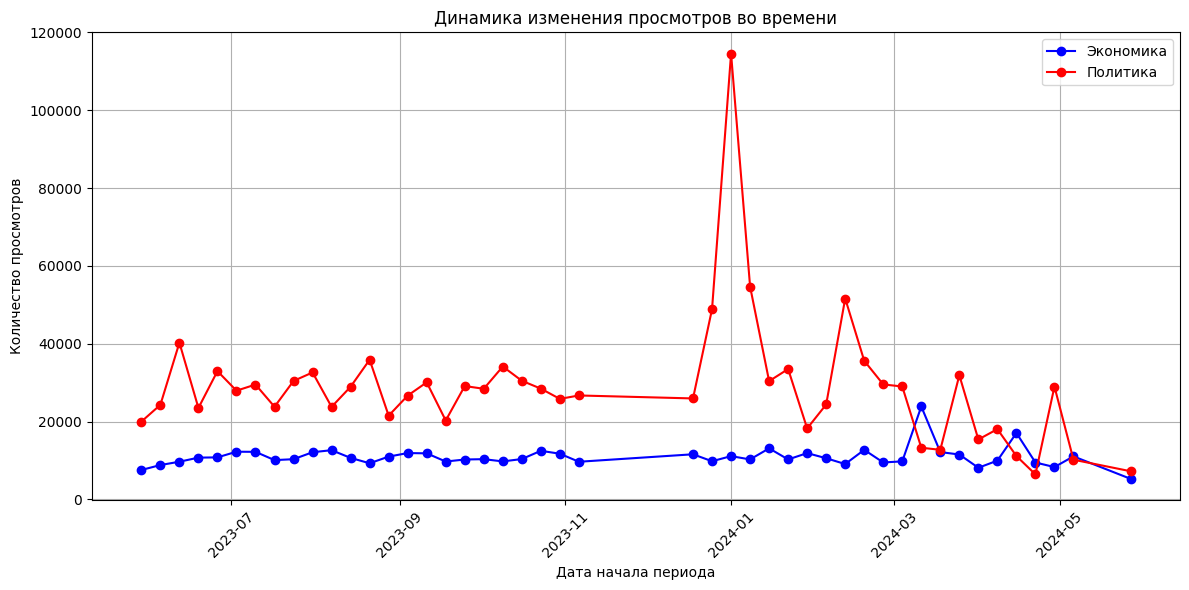

In [6]:
merged_df['Дата начала'] = pd.to_datetime(merged_df['Дата начала'])
merged_df['Дата окончания'] = pd.to_datetime(merged_df['Дата окончания'])
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Дата начала'], merged_df['Просмотры_экономика'], marker='o', linestyle='-', color='b', label='Экономика')
plt.plot(merged_df['Дата начала'], merged_df['Просмотры_политика'], marker='o', linestyle='-', color='r', label='Политика')
plt.title('Динамика изменения просмотров во времени')
plt.xlabel('Дата начала периода')
plt.ylabel('Количество просмотров')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h2>Категория "Политика" в июле 2023 года - январе 2024 года демонстрировала высокую волатильность с значительным ростом просмотров в январе 2024 года, что, вероятно, связано с важными политическими событиями. В то же время, категория "Экономика" оставалась стабильной и низкой по сравнению с политикой, с незначительным ростом в начале 2024 года.</h2>

<h2>Анализ тренда, сезонности</h2>

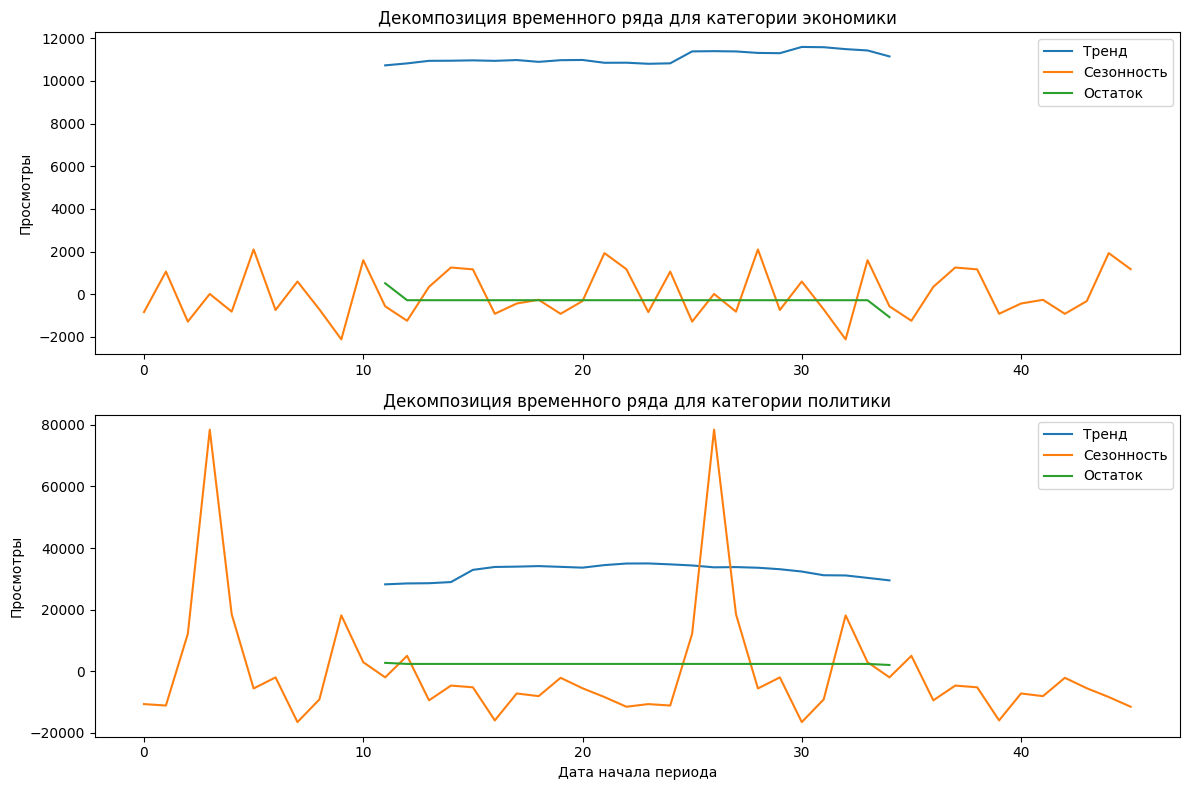

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose


result_economy = seasonal_decompose(merged_df['Просмотры_экономика'], model='additive', period=23)
result_politics = seasonal_decompose(merged_df['Просмотры_политика'], model='additive', period=23)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(merged_df.index, result_economy.trend, label='Тренд')
plt.plot(merged_df.index, result_economy.seasonal, label='Сезонность')
plt.plot(merged_df.index, result_economy.resid, label='Остаток')
plt.title('Декомпозиция временного ряда для категории экономики')
plt.ylabel('Просмотры')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(merged_df.index, result_politics.trend, label='Тренд')
plt.plot(merged_df.index, result_politics.seasonal, label='Сезонность')
plt.plot(merged_df.index, result_politics.resid, label='Остаток')
plt.title('Декомпозиция временного ряда для категории политики')
plt.xlabel('Дата начала периода')
plt.ylabel('Просмотры')
plt.legend()

plt.tight_layout()
plt.show()

<h3>Вывод:</h3>


<h4>Категория экономика демонстрирует стабильный интерес с почти неизменным уровнем просмотров в течение исследуемого периода. Сезонные колебания остаются минимальными, а модель декомпозиции показывает хорошее сопоставление данных с трендом и остаточными значениями близкими к нулю.
В отличие от этого, категория политики характеризуется значительной изменчивостью в интересе аудитории. Тренд показывает увеличение просмотров в середине периода, но сезонные колебания являются выраженными, что указывает на влияние внешних событий на интерес к данной тематике. Остаточные значения подтверждают адекватность модели, однако необходимость дополнительного изучения конкретных периодов пиков и спадов для полного понимания причин этих изменений.</h4>